In [3]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt

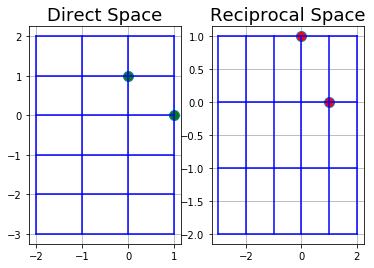

In [4]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt

class AnimXY: # Class used for animation
            def __init__(self,line=None,update=None): # constructor
                self.line=line
                self.press=None
                self.update=update # update fonction to call
                self.rmin=0.04 # distance to activate
                self.connect() # initialize connections
                
            def connect(self): # create 3 connections Press, Release, Pressed
                self.cidpress = self.line.figure.canvas.mpl_connect(
                    'button_press_event', self.on_press)
                self.cidrelease = self.line.figure.canvas.mpl_connect(
                    'button_release_event', self.on_release)
                self.cidmotion = self.line.figure.canvas.mpl_connect(
                    'motion_notify_event', self.on_motion)
                
            def on_press(self,event): # when pressed : update self.press         
                if event.inaxes != self.line.axes: return
                self.press=None
                xv,yv=self.line.get_xdata(),self.line.get_ydata()
             
                x,y=event.xdata,event.ydata # mouse position when click
                # find nearest
                for i in range(len(xv)):
                    r=(xv[i]-x)**2+(yv[i]-y)**2
                    if (r<self.rmin):
                        self.press=i,event.xdata,event.ydata # update position
                        
            def on_motion(self,event):
                'on button press move the line data number i'
                if self.press is None: return # no already pressed?
                if event.inaxes!=self.line.axes: return # no click in axes?
                i,xp,yp=self.press
                dx,dy=event.xdata-xp,event.ydata-yp # translation
                self.xv,self.yv=self.line.get_xdata(),self.line.get_ydata()
                self.yv[i]+=dy
                self.xv[i]+=dx
                self.press=i,event.xdata,event.ydata
                self.line.set_xdata(self.xv)
                self.line.set_ydata(self.yv)
                self.line.figure.canvas.draw()
                if self.update != None:
                    self.update(np.array([self.xv,self.yv])) # call update function
            def on_release(self,event):
                self.press = None
                self.line.figure.canvas.draw()
            def disconnect(self):
                'disconnect all the stored connection ids'
                self.line.figure.canvas.mpl_disconnect(self.cidpress)
                self.line.figure.canvas.mpl_disconnect(self.cidrelease)
                self.line.figure.canvas.mpl_disconnect(self.cidmotion)

class DemoRLattice:
    #NOTE : a base is a SET of two Vectors included in a 2x2 matrix
    def abRecip(self,ab): # compute Reciprocal base for a given base (Direct or Reciprocal)
        M=np.array([[0.,1.],[1.,0.]]) # antisymetric matrix
        n2=np.linalg.norm(ab[:,0])*np.linalg.norm(ab[:,1])# product of norms  ||a|| x ||b||
        abR=(np.dot(M,ab))/n2
        return np.array(abR)
    
    def updateRR(self,ab):#,ab=[[1.,0.],[0.,1.]]):
        self.abR=self.abRecip(ab)
        self.ab=ab
        self.line_abRR.set_data(self.abR)
        self.reDrawLattice()       
        
    def updateRD(self,ab):
        self.ab=self.abRecip(ab)
        self.abR=ab
        self.line_abRD.set_data(self.ab)
        self.reDrawLattice()
        
    def reDrawLattice(self):
        xiyi=self.lineLattice(self.ab,self.na,self.nb)
        self.updateLattice(xiyi,self.linesRD)        
        xiyi=self.lineLattice(self.abR,self.na,self.nb)        
        self.updateLattice(xiyi,self.linesRR)
    
    def updateLattice(self,xiyi, lines):
        j=0
        xi,yi=xiyi
        for line in lines:
            line.set_data([xi[:,j],yi[:,j]])
            j+=1         
    
    def lineLattice(self,ab,na,nb):
        'initialize a lattice'
        xi1=np.array([[j*ab[0,1]-(na)*ab[0,0],j*ab[0,1]+(na-1)*ab[0,0]] for j in range(-nb,nb)])
        yi1=np.array([[j*ab[1,1]-(na)*ab[1,0],j*ab[1,1]+(na-1)*ab[1,0]] for j in range(-nb,nb)])
        xi2=np.array([[j*ab[0,0]-(nb)*ab[0,1],j*ab[0,0]+(nb-1)*ab[0,1]] for j in range(-na,na)])
        yi2=np.array([[j*ab[1,0]-(nb)*ab[1,1],j*ab[1,0]+(nb-1)*ab[1,1]] for j in range(-na,na)])
        xi=np.concatenate((xi1.T,xi2.T),1)
        yi=np.concatenate((yi1.T,yi2.T),1)
        return xi,yi
    
    def drawLattice(self,xiyi,ax):
        xi,yi=xiyi
        lines=ax.plot(xi,yi,'-b')
        return lines
        
    def __init__(self,ab=[[1.,0.],[0.,1.]],na=4,nb=3):#constructor
            # initialize attributes 
            self.ab=np.array(ab)           # ab 2 vectors of direct lattice
            self.abR=self.abRecip(self.ab) # ab 2 vectors of Reciprocal irect lattice
            self.na,self.nb=na,nb 
            # initialize figure with two subplot
            fig = plt.figure()
            self.axRD = fig.add_subplot(121)
            plt.grid()
            plt.title('Direct Space',fontsize=18)
            self.axRR = fig.add_subplot(122)
            plt.grid()
            plt.title('Reciprocal Space',fontsize=18)
            # define 2 axes
            self.line_abRD,=self.axRD.plot(self.ab[0,:],self.ab[1,:],
                                           'o',markersize=10,markerfacecolor='g')
            self.line_abRR,=self.axRR.plot(self.abR[0,:],self.abR[1,:],
                                           'o',markersize=10,markerfacecolor='r')
            #draw 2Lattices
            xiyi=self.lineLattice(self.ab,na,nb)
            self.linesRD=self.drawLattice(xiyi,self.axRD)
            xiyi=self.lineLattice(self.abR,na,nb)
            self.linesRR=self.drawLattice(xiyi,self.axRR)
            # two animate Objects from AnimXY class with "crossed" interactions
            self.animRD=AnimXY(line=self.line_abRD,update=self.updateRR)
            self.animRR=AnimXY(line=self.line_abRR,update=self.updateRD)
            plt.show()
            self.axRR.axis('equal')
            self.axRD.axis('equal')

if __name__ == "__main__":    # execute in main module
    demo=DemoRLattice(na=2,nb=3)
            